In [1]:
##
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] =  False

In [2]:
##
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/amazon_revenue_profit.csv')
df.head(2)

,Quarter,Revenue,Net Income
0,3/31/2020,75452,2535
1,12/31/2019,87437,3268


In [3]:
##
df['Quarter'] = pd.to_datetime(df['Quarter'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Quarter     61 non-null     datetime64[ns]
 1   Revenue     61 non-null     int64         
 2   Net Income  61 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.6 KB


In [4]:
# check
df.head()

,Quarter,Revenue,Net Income
0,2020-03-31,75452,2535
1,2019-12-31,87437,3268
2,2019-09-30,69981,2134
3,2019-06-30,63404,2625
4,2019-03-31,59700,3561


In [5]:
##
fig = px.line(df, x = 'Quarter', y = 'Revenue', title = 'Amazon Profits')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list(
            [
             dict(count = 1, label = '1y', step = "year", stepmode = 'backward'),
             dict(count = 2, label = '3y', step = "year", stepmode = 'backward'),
             dict(count = 3, label = '5y', step = "year", stepmode = 'backward'),
             dict(step = "all"),
            ]
        )
    )
)

fig.show()

In [6]:
##
from fbprophet import Prophet

In [8]:
amazon_df = df[['Quarter', 'Revenue']].rename({'Quarter':'ds', 'Revenue':'y'}, axis = 'columns')
amazon_df

,ds,y
0,2020-03-31,75452
1,2019-12-31,87437
2,2019-09-30,69981
3,2019-06-30,63404
4,2019-03-31,59700
...,...,...
56,2006-03-31,2279
57,2005-12-31,2977
58,2005-09-30,1858
59,2005-06-30,1753


In [9]:
## Splitting train and test datasets
train = amazon_df[(amazon_df['ds'] >= '2005-03-31') & (amazon_df['ds'] <= '2019-03-31')]
test = amazon_df[amazon_df['ds'] > '2019-03-31']

In [10]:
print(train.shape)
print(test.shape)

(57, 2)
(4, 2)


In [11]:
## model
m = Prophet(interval_width=0.95)

In [12]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
## 
future = m.make_future_dataframe(periods=4, freq='Q')
future.tail()

,ds
56,2019-03-31
57,2019-06-30
58,2019-09-30
59,2019-12-31
60,2020-03-31


In [14]:
##
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56,2019-03-31,61089.496702,57177.469757,65048.807430
57,2019-06-30,63195.117245,59044.795192,66886.011185
58,2019-09-30,66153.769212,62235.055602,70153.827555
59,2019-12-31,74249.538229,69868.157620,78232.632140
60,2020-03-31,70663.367667,66615.908369,74893.610163


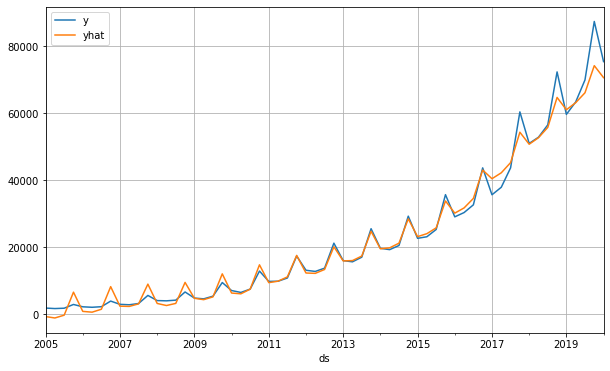

In [15]:
#
pd.concat([amazon_df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot(figsize=(10,6), grid=True);

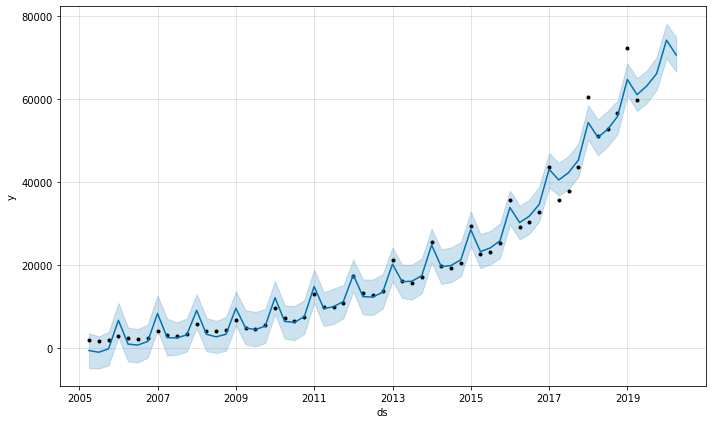

In [16]:
fig1 = m.plot(forecast)

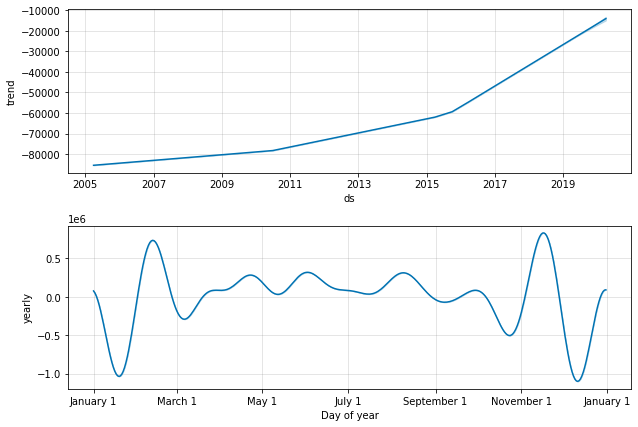

In [17]:
fig2 = m.plot_components(forecast)

In [18]:
##
holiday_sale = pd.DataFrame({
    'holiday':'dec_jan_sale',
    'ds': pd.to_datetime([
                          '2019-12-31', '2018-12-31', '2017-12-31', '2016-12-31', '2015-12-31', '2014-12-31',
                          '2013-12-31', '2012-12-31', '2011-12-31', '2010-12-31', '2009-12-31', '2008-12-31',
                          '2007-12-31', '2006-12-31', '2005-12-31'
    ]),
    'lower_window':0,
    'upper_window':1,
})
holiday_sale

,holiday,ds,lower_window,upper_window
0,dec_jan_sale,2019-12-31,0,1
1,dec_jan_sale,2018-12-31,0,1
2,dec_jan_sale,2017-12-31,0,1
3,dec_jan_sale,2016-12-31,0,1
4,dec_jan_sale,2015-12-31,0,1
5,dec_jan_sale,2014-12-31,0,1
6,dec_jan_sale,2013-12-31,0,1
7,dec_jan_sale,2012-12-31,0,1
8,dec_jan_sale,2011-12-31,0,1
9,dec_jan_sale,2010-12-31,0,1


In [19]:
m2 = Prophet(interval_width=0.95, seasonality_mode='multiplicative', holidays=holiday_sale)

In [20]:
m2.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
forecast = m2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56,2019-03-31,60105.339695,58461.084968,61970.461460
57,2019-06-30,62632.831894,60768.270422,64487.376596
58,2019-09-30,67797.199969,66063.631970,69543.829402
59,2019-12-31,89334.669448,87481.731699,91250.229375
60,2020-03-31,66853.826595,64963.490673,68921.462358


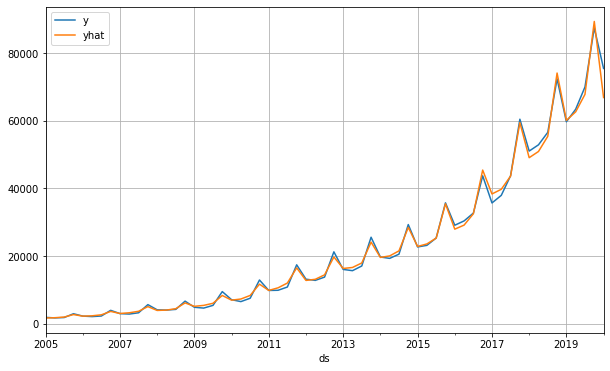

In [22]:
#
pd.concat([amazon_df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot(figsize=(10,6), grid=True);

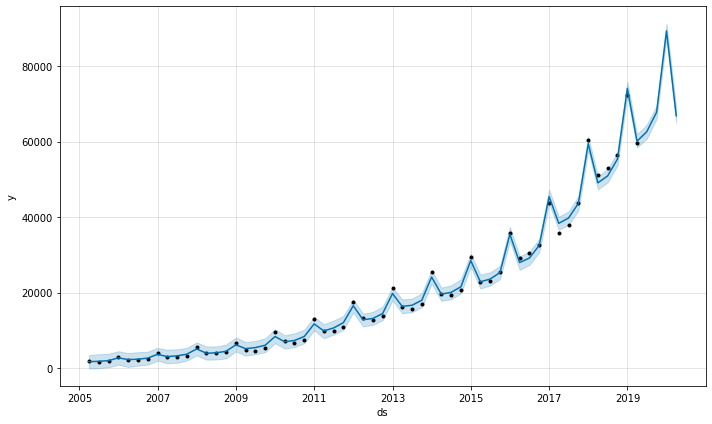

In [23]:
fig1 = m2.plot(forecast)

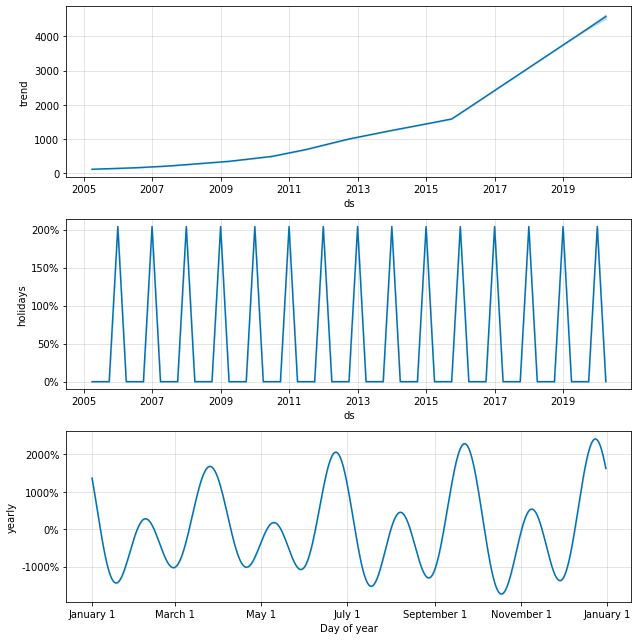

In [24]:
fig2 = m2.plot_components(forecast)